In [1]:
import jCMIP as jc
Clist = jc.readList(('CMIP6listnew'))

from netCDF4 import Dataset
from netCDF4 import num2date
import numpy as np
from scipy.integrate import quad
from scipy import stats as st
import matplotlib.pyplot as plt
from matplotlib import colors
import cftime
import gsw
from datetime import date, timedelta
import pandas as pd
from scipy.interpolate import interp1d
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

#### Historical

In [2]:
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r2i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f3',
           'r1i1p1f3','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
EXP    = 'historical'

t10 = 129
NADW10Ntot = np.zeros((t10,len(totmod)))
NADW10Stot = np.zeros((t10,len(totmod)))
for i in range (len(totmod)):
    outfile = ('/home/users/jordi/components_tpBS_recir/' + totmod[i] + '_' + EXP + '_' + ENS[i] + '.nc')
    ncid    = Dataset(outfile,'r')      
    NADW10N = ncid.variables['NADW10N'][:]     
    NADW10S = ncid.variables['NADW10S'][:]          
    ncid.close()
    
    NADW10Ntot[:,i]    = NADW10N
    NADW10Stot[:,i]    = NADW10S
        
#Calculate ensemble mean transport of all components
NADWNmean = np.nanmean(NADW10Ntot,axis=1)
NADWSmean = np.nanmean(NADW10Stot,axis=1)
NADWNstd  = np.std(NADW10Ntot,axis=1)
NADWSstd  = np.std(NADW10Stot,axis=1)

#Calculate time mean of all models
NADWNtmean = np.nanmean(NADW10Ntot,axis=0)
NADWStmean = np.nanmean(NADW10Stot,axis=0)

NADW_df = pd.DataFrame(data=np.transpose([NADWNtmean,NADWStmean]),columns=['Interior','DWBC'],index=totmod)

#Change time to date
outfile = ('/home/users/jordi/section26data/' + totmod[6] + '_' + EXP + '_' + ENS[6] + '.nc')  #CNRM-CM6-1 has gregorian calendar, which is supported by python datetime objects
ncid    = Dataset(outfile,'r')
time    = ncid.variables['time'][-129::]
units   = ncid.variables['time'].units
cal     = ncid.variables['time'].calendar
ncid.close()

tdate   = cftime.num2pydate(time,units)

##### Ensemble mean time series

0.9575780503750997
-17.486839063600392
N 2.9812840395428206
S 2.8702710440778305
N mod 9.32742758144611
S mod 13.673085388083948
2007-09-16 00:00:00
2013-01-16 12:00:00


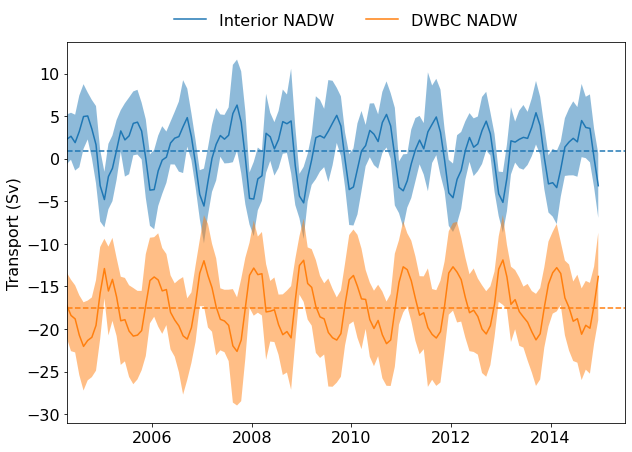

In [13]:
plt.figure(1,figsize=(10,7))
plt.plot(tdate,NADWNmean,label='Interior NADW')
plt.fill_between(tdate,NADWNmean-NADWNstd,NADWNmean+NADWNstd,alpha=0.5)
plt.plot(tdate,NADWSmean,label='DWBC NADW')
plt.fill_between(tdate,NADWSmean-NADWSstd,NADWSmean+NADWSstd,alpha=0.5)
plt.axhline(y=np.nanmean(NADWNmean),linestyle='--',color='tab:blue')
plt.axhline(y=np.nanmean(NADWSmean),linestyle='--',color='tab:orange')
plt.legend(loc='lower center',bbox_to_anchor=(0.5,1),ncol=2,prop={'size': 16},frameon=False)
plt.xlim(left=tdate[0])
plt.ylabel('Transport (Sv)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

histmean_NADWN = np.nanmean(NADWNmean)
histmean_NADWS = np.nanmean(NADWSmean)

print(histmean_NADWN)
print(histmean_NADWS)

print(tdate[np.argmin(NADWSmean)])
print(tdate[np.argmax(NADWSmean)])

##### Timeseries of every model

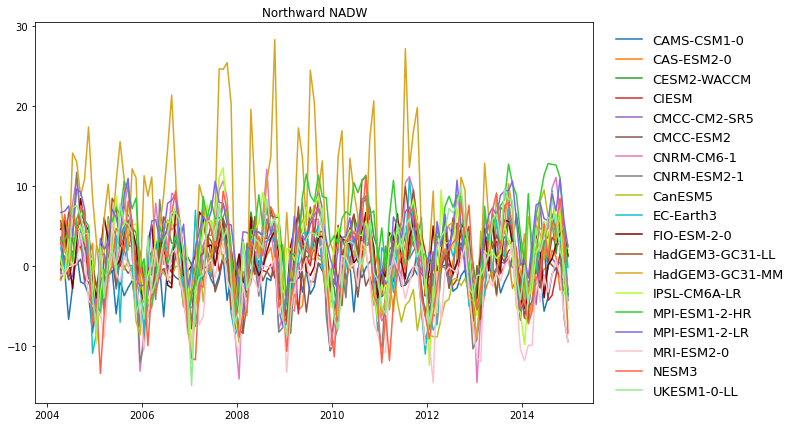

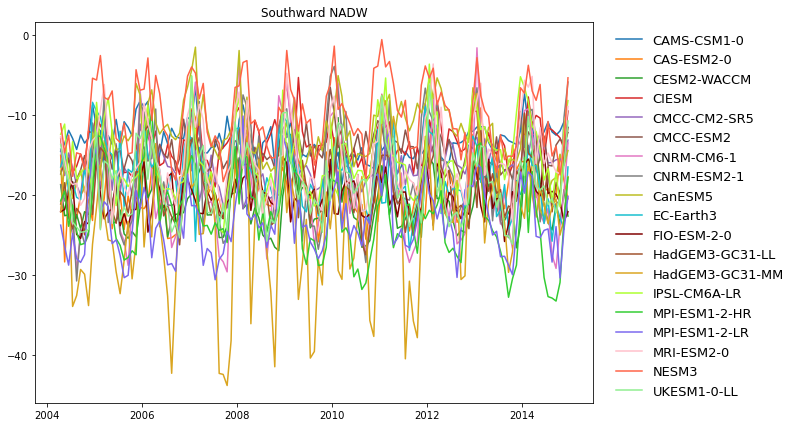

In [8]:
plt.figure(1,figsize=(10,7))
plt.gca().set_prop_cycle(color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','maroon','sienna','goldenrod','greenyellow','limegreen','mediumslateblue','pink','tomato','lightgreen'])
plt.figure(2,figsize=(10,7))
plt.gca().set_prop_cycle(color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','maroon','sienna','goldenrod','greenyellow','limegreen','mediumslateblue','pink','tomato','lightgreen'])
for i in range(len(totmod)):
    plt.figure(1,figsize=(10,7))
    plt.title('Northward NADW')
    plt.plot(tdate,NADW10Ntot[:,i],label=totmod[i])
    plt.legend(bbox_to_anchor=(1.02, 1),prop={'size': 13},frameon=False)
    plt.figure(2,figsize=(10,7))
    plt.title('Southward NADW')
    plt.plot(tdate,NADW10Stot[:,i],label=totmod[i])
    plt.legend(bbox_to_anchor=(1.02, 1),prop={'size': 13},frameon=False)


##### Plots (x,z) of deep transport (i.e. below imax)

/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


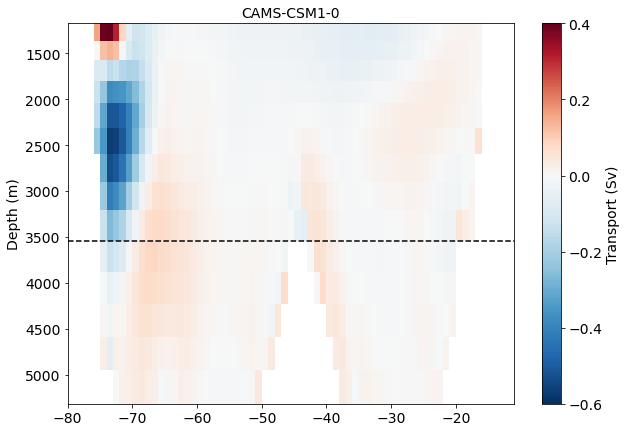

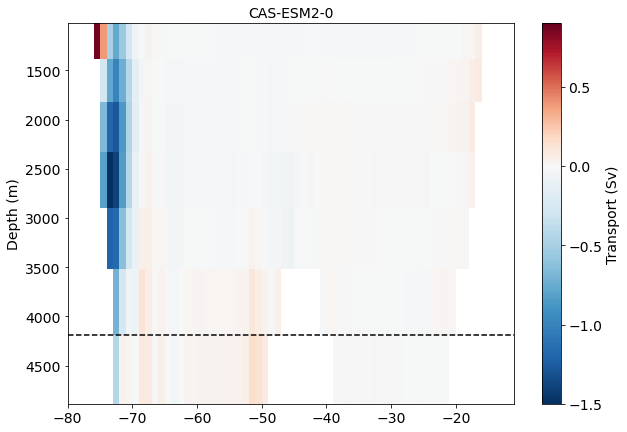

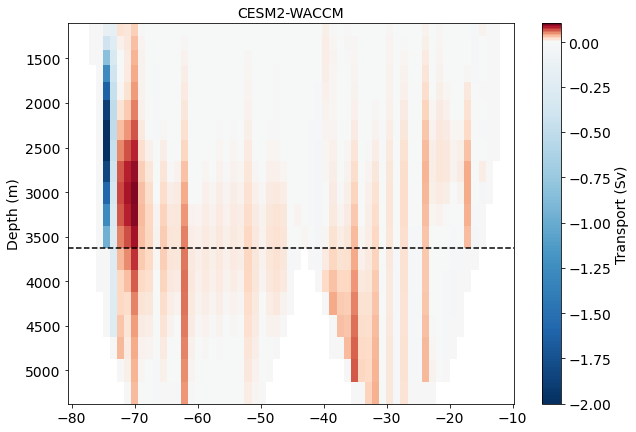

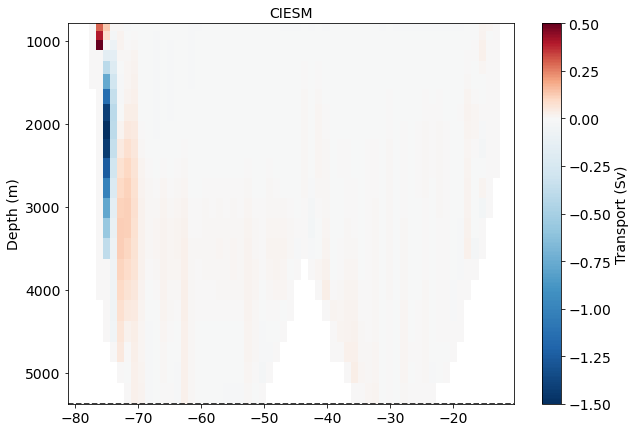

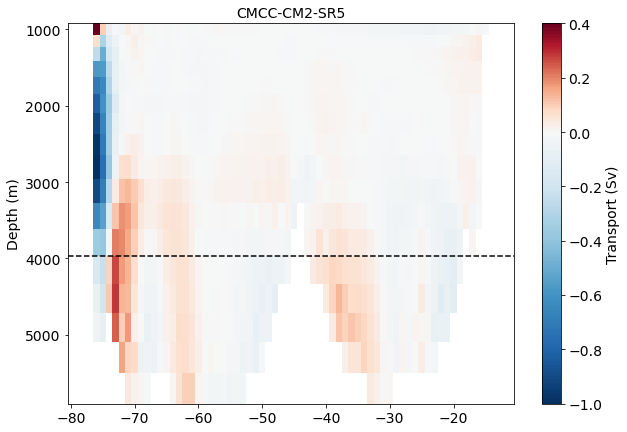

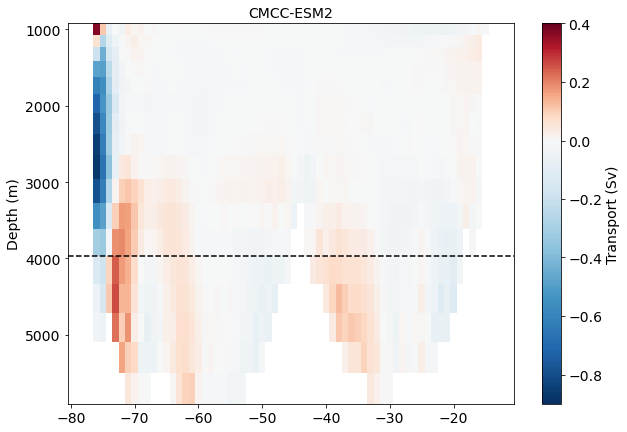

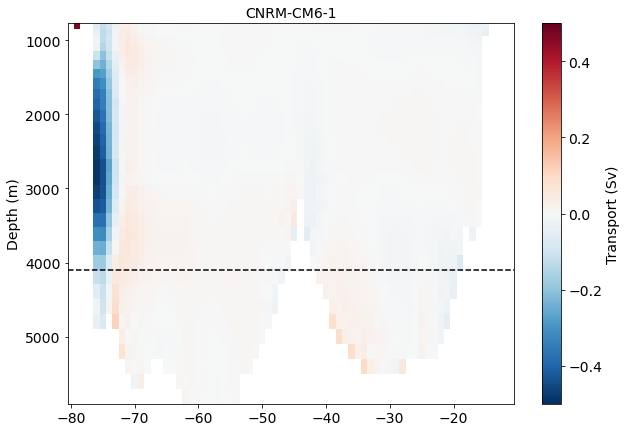

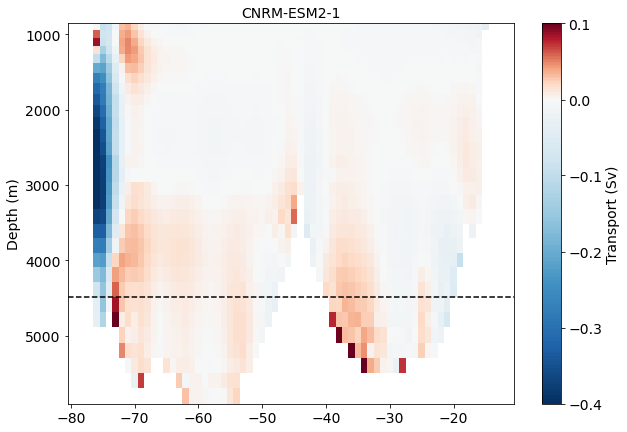

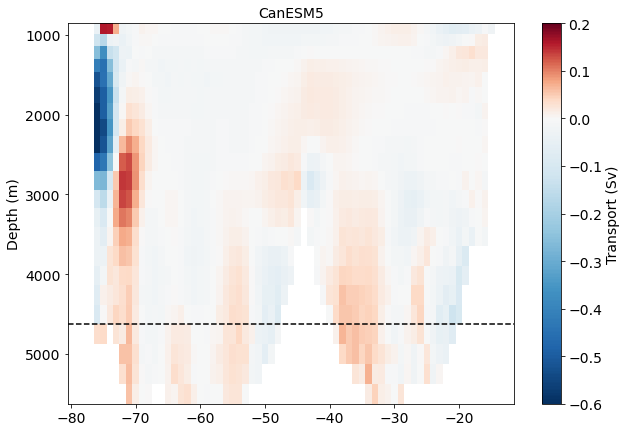

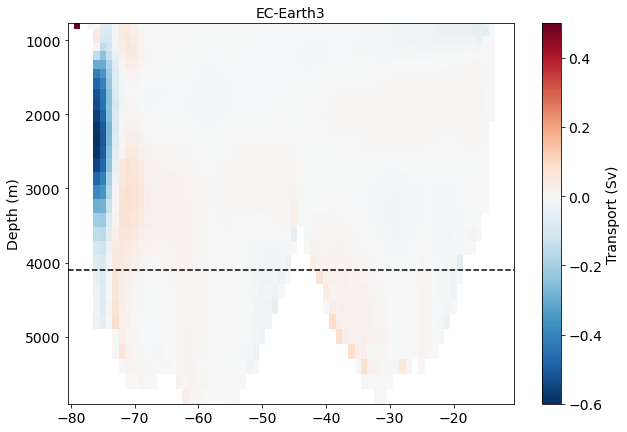

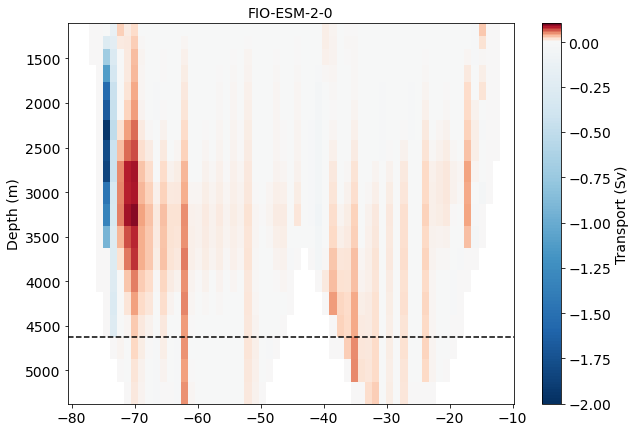

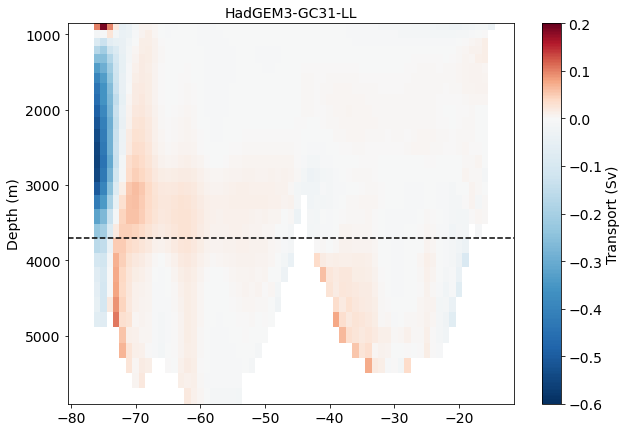

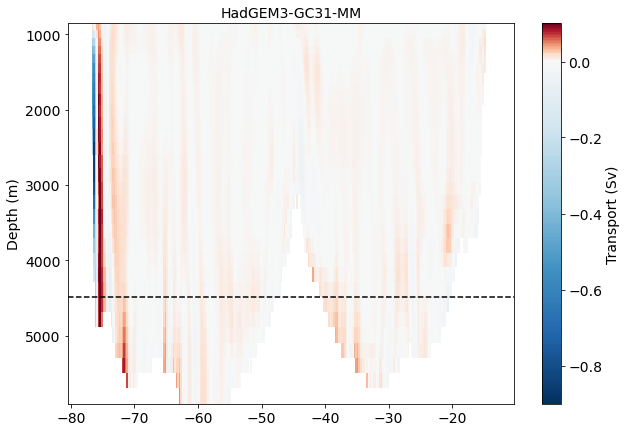

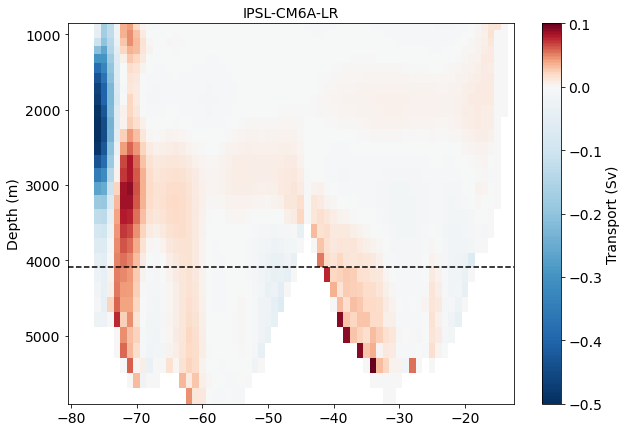

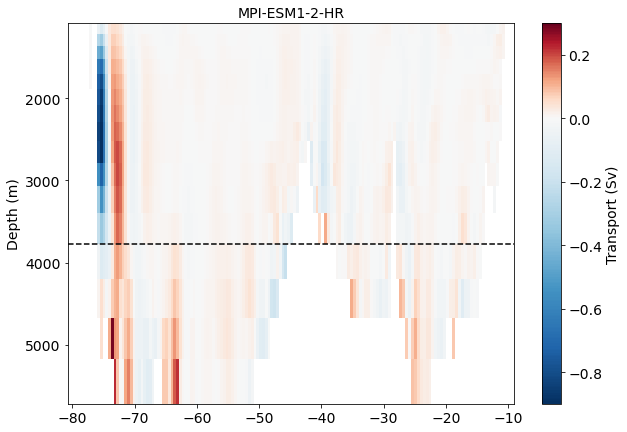

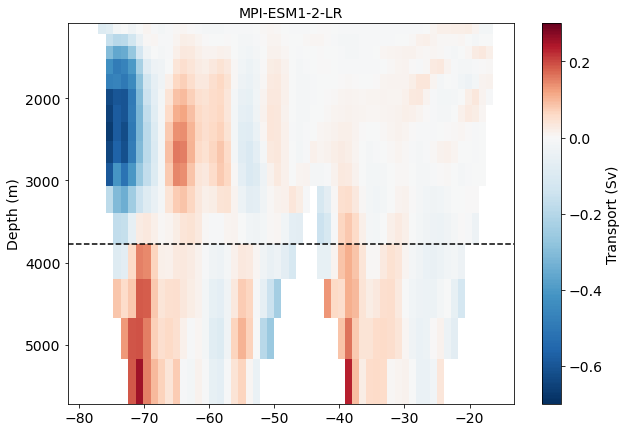

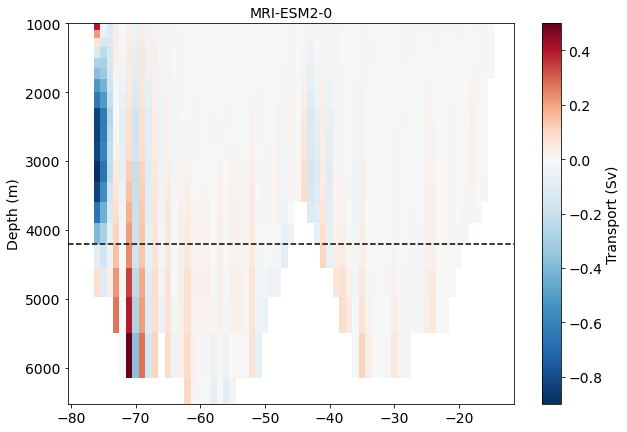

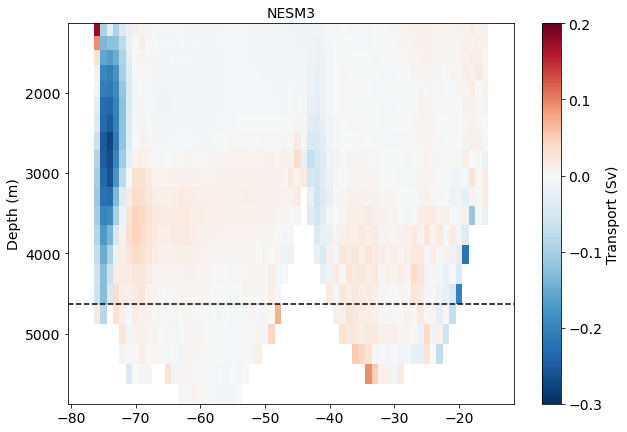

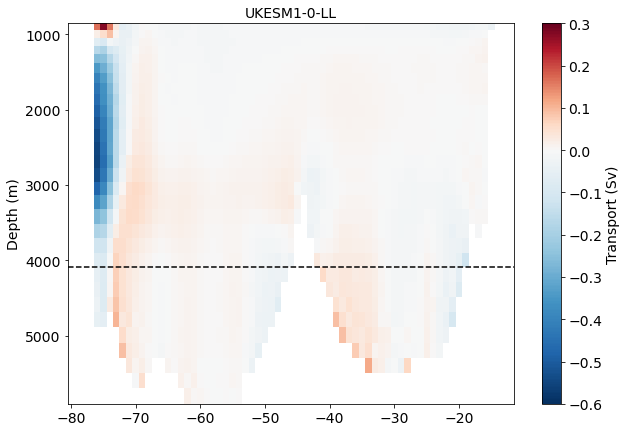

In [6]:
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r2i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f3',
           'r1i1p1f3','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
EXP   = 'historical'

for mod in range (len(totmod)):
    outfile = ('/home/users/jordi/section26data/' + totmod[mod] + '_' + EXP + '_' + ENS[mod] + '.nc')
    ncid    = Dataset(outfile,'r')
    lev     = ncid.variables['lev'][:]
    lat     = np.squeeze(ncid.variables['lat'][:,:])
    lon     = np.squeeze(ncid.variables['lon'][:,:])
    tp10    = ncid.variables['tp10_BS'][:,:,:]
    dx      = ncid.variables['dx'][0,:]
    ncid.close()
    
    tprow10    = np.nansum(np.nanmean(tp10,axis=0),axis=1)
    mocbtv     = -1*np.nancumsum(tprow10[::-1])[::-1]
    ilevmin    = np.nanargmin(np.abs(lev-200))         #Find index where lev = 200, so outlier where imax = 0 is solved
    ilevmax    = np.nanargmin(np.abs(lev-2000))         #Find index where lev = 2000, so outlier where imax = -1 is solved
    imax2      = np.where(mocbtv[ilevmin:ilevmax] == max(mocbtv[ilevmin:ilevmax]))
    imax1      = imax2[0]
    imaxmean   = imax1[0] + ilevmin
        
    #Aidx
    tprow10low = tprow10[int(imaxmean)::]
    for m in range (1,len(tprow10low)):                    #start at 1, otherwise the first and last point will be compared
        if tprow10low[m]>0 and tprow10low[m-1]<0:
            Aidxmean = m + imaxmean
                
    AABWcheck = tprow10low[int(Aidxmean)::]                    #Make sure sum(AABW) is positive
    if sum(AABWcheck) < 0:
        Aidxmean = len(tprow10low) - 1
    
    if totmod[mod] in ['CESM2-WACCM','CIESM','FIO-ESM-2-0']:        #Correct for shift Atlantic
        lon = lon - 100

        
    plt.figure(mod,(10,7))
    plt.title(totmod[mod],fontsize=14)
    divnorm=colors.TwoSlopeNorm(vmin=np.round(np.nanmin(np.nanmean(tp10[:,int(imaxmean)::,:],axis=0)),1), vcenter=0., vmax=np.round(np.nanmax(np.nanmean(tp10[:,int(imaxmean)::,:],axis=0)),1))
    plt.pcolormesh(lon,lev[int(imaxmean)::],np.nanmean(tp10[:,int(imaxmean)::,:],axis=0),cmap='RdBu_r',norm=divnorm)
    plt.gca().invert_yaxis()
    plt.axhline(y=lev[int(Aidxmean)],color='k',linestyle='--')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    cbar = plt.colorbar()
    cbar.set_label('Transport (Sv)',size=14)
    cbar.ax.tick_params(labelsize=14)   
    plt.ylabel('Depth (m)',fontsize=14)

##### Time mean vertically summed transport for every model

/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/users/j

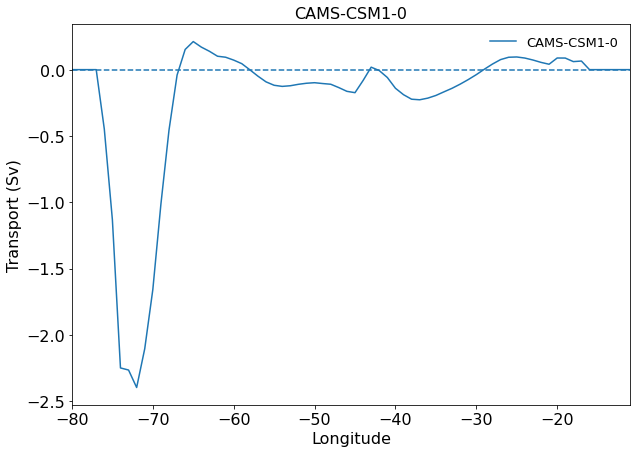

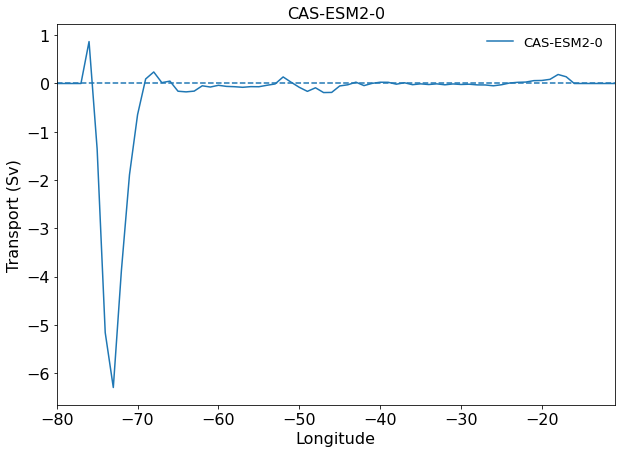

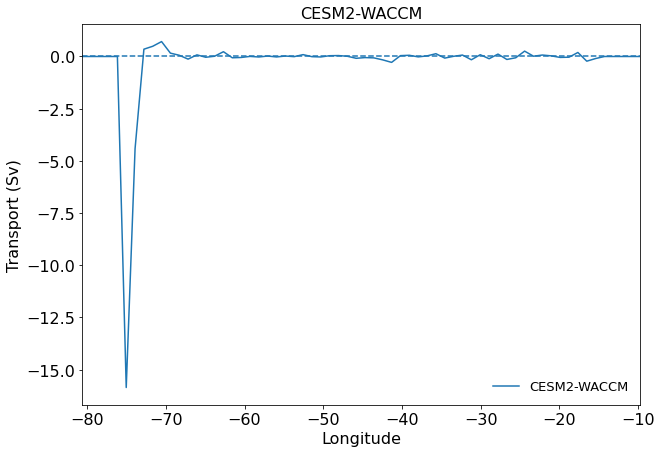

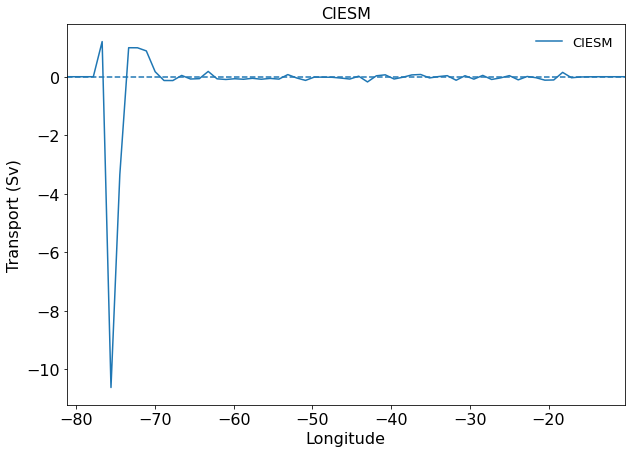

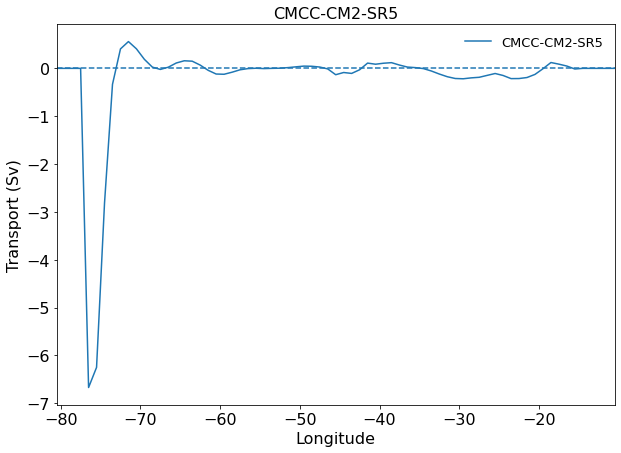

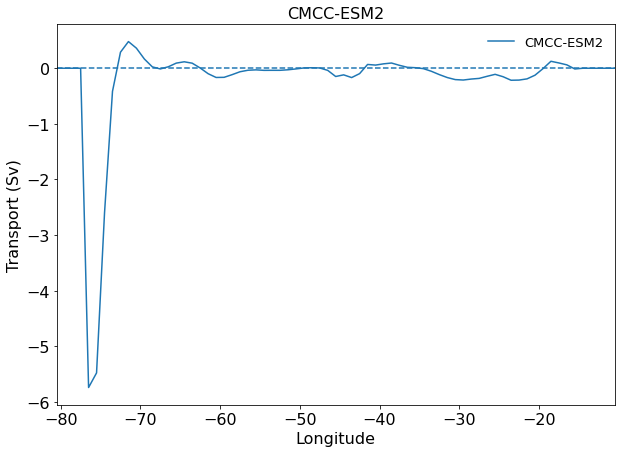

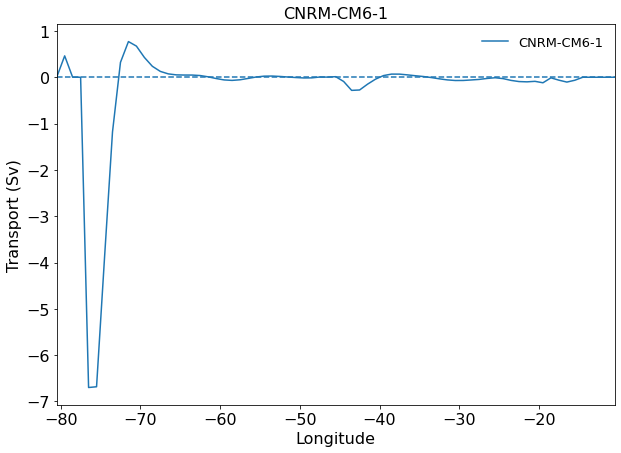

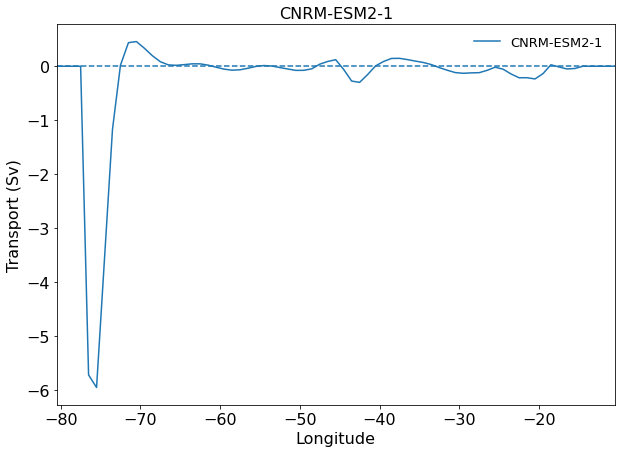

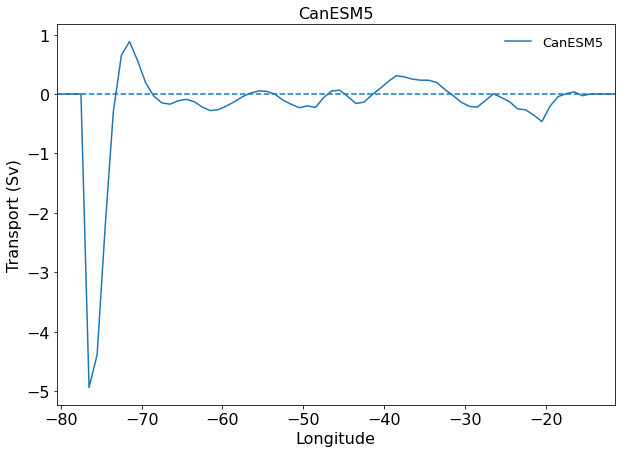

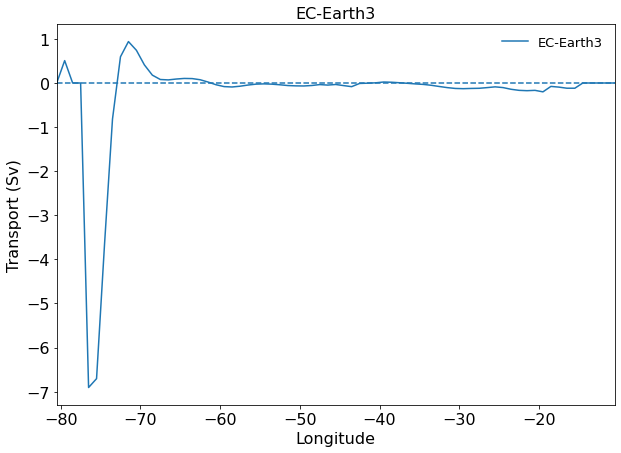

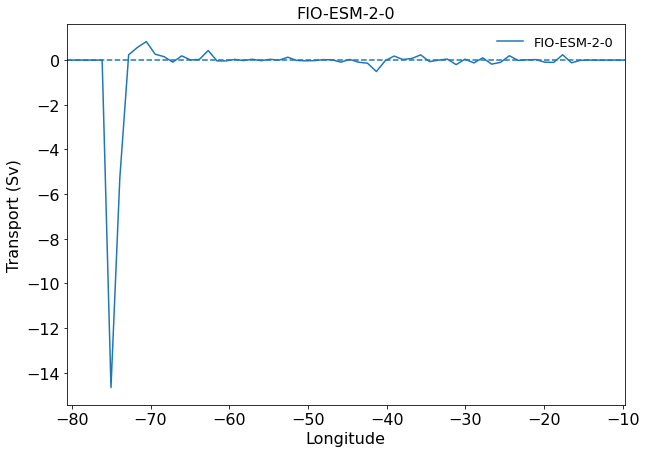

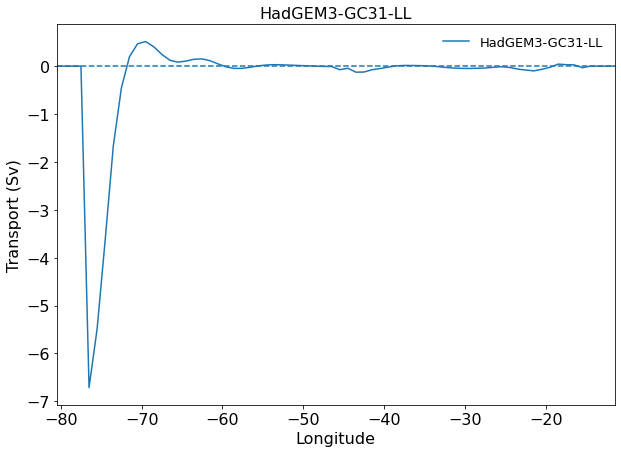

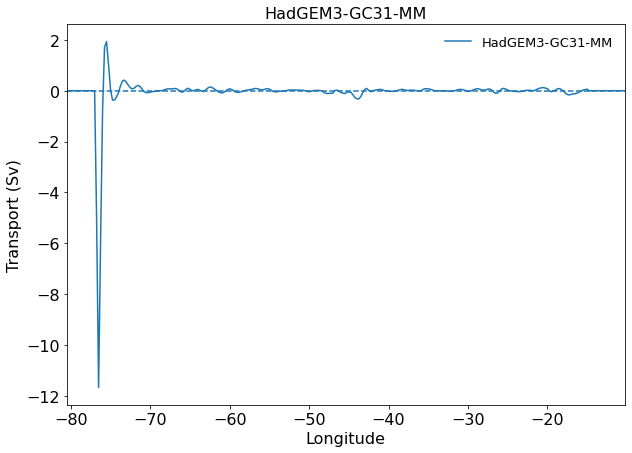

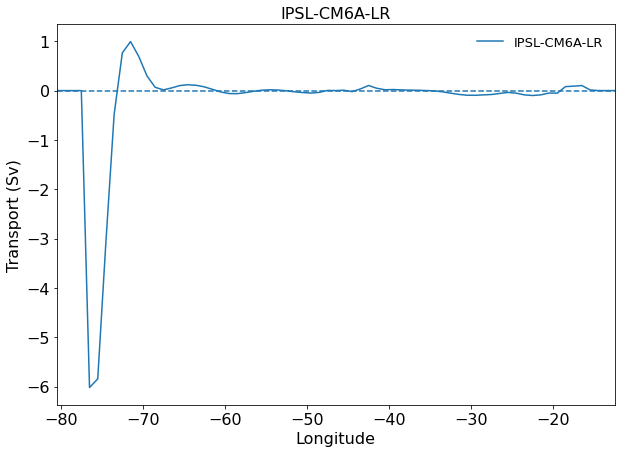

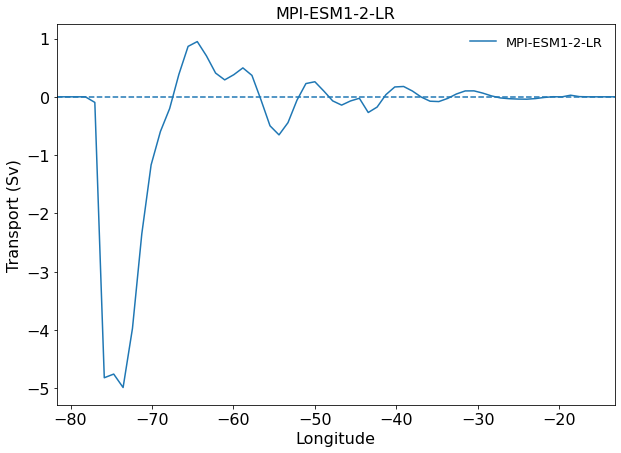

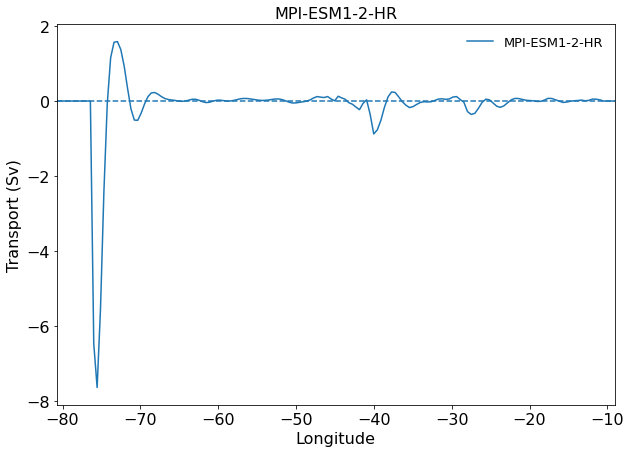

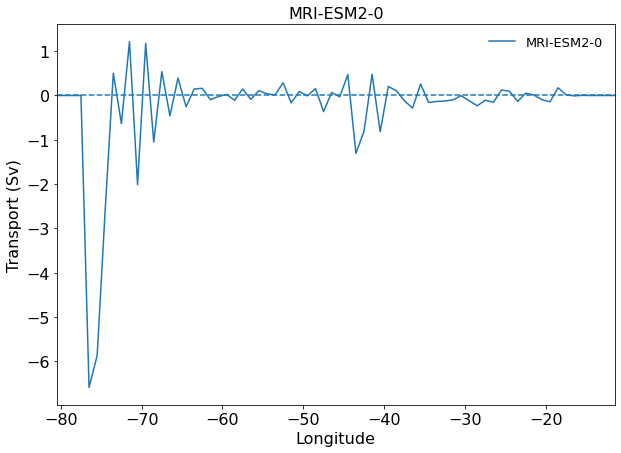

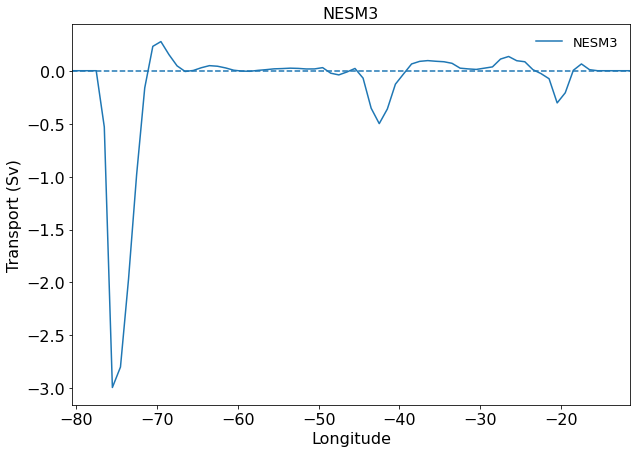

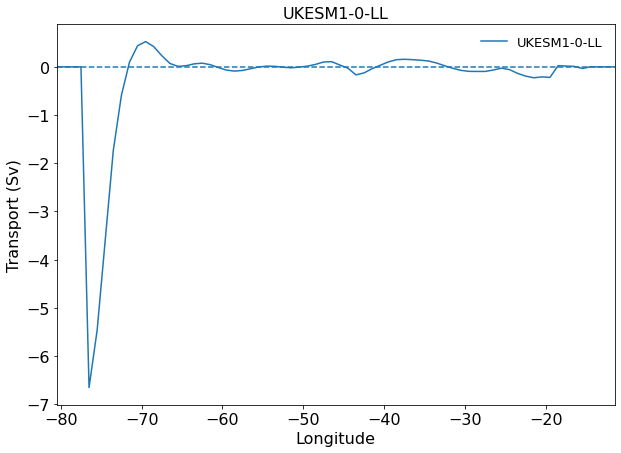

In [5]:
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-LR','MPI-ESM1-2-HR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r2i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f3',
           'r1i1p1f3','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
EXP   = 'historical'

plt.figure(1,figsize=(10,7))
plt.figure(2,figsize=(10,7))
plt.gca().set_prop_cycle(color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','maroon','sienna','goldenrod','greenyellow','limegreen','mediumslateblue','pink','tomato','lightgreen'])
for mod in range (len(totmod)):
    outfile = ('/home/users/jordi/section26data/' + totmod[mod] + '_' + EXP + '_' + ENS[mod] + '.nc')
    ncid    = Dataset(outfile,'r')
    lev     = ncid.variables['lev'][:]
    lat     = np.squeeze(ncid.variables['lat'][:,:])
    lon     = np.squeeze(ncid.variables['lon'][:,:])
    tp10    = ncid.variables['tp10_BS'][:,:,:]
    dx      = ncid.variables['dx'][0,:]
    ncid.close()
      
    tprow10    = np.nansum(np.nanmean(tp10,axis=0),axis=1)
    mocbtv     = -1*np.nancumsum(tprow10[::-1])[::-1]
    ilevmin    = np.nanargmin(np.abs(lev-200))         #Find index where lev = 200, so outlier where imax = 0 is solved
    ilevmax    = np.nanargmin(np.abs(lev-2000))         #Find index where lev = 2000, so outlier where imax = -1 is solved
    imax2      = np.where(mocbtv[ilevmin:ilevmax] == max(mocbtv[ilevmin:ilevmax]))
    imax1      = imax2[0]
    imaxmean   = imax1[0] + ilevmin
        
    #Aidx
    tprow10low = tprow10[int(imaxmean)::]
    for m in range (1,len(tprow10low)):                    #start at 1, otherwise the first and last point will be compared
        if tprow10low[m]>0 and tprow10low[m-1]<0:
            Aidxmean = m + imaxmean
                
    AABWcheck = tprow10low[int(Aidxmean)::]                    #Make sure sum(AABW) is positive
    if sum(AABWcheck) < 0:
        Aidxmean = len(tprow10low) - 1
    
    if totmod[mod] in ['CESM2-WACCM','CIESM','FIO-ESM-2-0']:        #Correct for shift Atlantic
        lon = lon - 100
    
    
    NADWcol_test = np.nansum(tp10[:,int(imaxmean):int(Aidxmean),:],axis=1)
    NADWcolmean = np.nansum(np.nanmean(tp10[:,int(imaxmean):int(Aidxmean),:],axis=0),axis=0)    
    #NADWcolmean = np.nanmean(NADWcol,axis=0)
    mxNADW   = np.nanargmin(NADWcolmean)
    idx2NADW = np.where(NADWcolmean[mxNADW::]>0)                      #Make sure idx > mx (max(tpcol10))
    idx1NADW = idx2NADW[0]
    idxNADW  = idx1NADW[0] + mxNADW

    plt.figure(mod,figsize=(10,7))
    plt.title(totmod[mod],fontsize=16)
    plt.plot(lon,NADWcolmean,label=totmod[mod])
    plt.axhline(y=0,linestyle='--')
    plt.xlabel('Longitude',fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylabel('Transport (Sv)',fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim(left=lon[0],right=lon[-1])
    plt.legend(prop={'size': 13},frameon=False)

    
    #Plot colmean of DWBC and interior NADW for every model
    #plt.figure(1,figsize=(10,7))
    #plt.title('DWBC NADW',fontsize=14)
    #plt.plot(lon[0:idxNADW],NADWcolmean[0:idxNADW],label=totmod[mod])
    #plt.xlabel('Longitude',fontsize=14)
    #plt.xticks(fontsize=14)
    #plt.ylabel('Transport (Sv)',fontsize=14)
    #plt.yticks(fontsize=14)
    
    #plt.figure(2,figsize=(10,7))
    #plt.title('Interior NADW',fontsize=14)
    #plt.plot(lon[idxNADW::],NADWcolmean[idxNADW::],label=totmod[mod]) 
    #plt.xlabel('Longitude',fontsize=14)
    #plt.xticks(fontsize=14)
    #plt.ylabel('Transport (Sv)',fontsize=14)
    #plt.yticks(fontsize=14)

    #Compare models with different resolutions
    #if totmod[mod] in ['HadGEM3-GC31-LL','HadGEM3-GC31-MM']:
    #    plt.figure(1,figsize=(10,7))
    #    #plt.title(totmod[mod],fontsize=16)
    #    plt.plot(lon,NADWcolmean,label=totmod[mod])
    #    plt.axhline(y=0,linestyle='--')
    #    plt.xlabel('Longitude',fontsize=16)
    #    plt.xticks(fontsize=16)
    #    plt.ylabel('Transport (Sv)',fontsize=16)
    #    plt.yticks(fontsize=16)
    #    plt.xlim(left=lon[0],right=lon[-1])
    #    plt.legend(prop={'size': 13},frameon=False)

    #if totmod[mod] in ['MPI-ESM1-2-LR','MPI-ESM1-2-HR']:
    #    plt.figure(2,figsize=(10,7))
        #plt.title(totmod[mod],fontsize=16)
    #    plt.plot(lon,NADWcolmean,label=totmod[mod])
    #    plt.axhline(y=0,linestyle='--')
    #    plt.xlabel('Longitude',fontsize=16)
    #    plt.xticks(fontsize=16)
    #    plt.ylabel('Transport (Sv)',fontsize=16)
    #    plt.yticks(fontsize=16)
    #    plt.xlim(left=lon[0],right=lon[-1])
    #    plt.legend(prop={'size': 13},frameon=False)
    
    #Plot colmean during minimum and maximum
    #t_min = np.argmax(np.nanmin(NADWcol_test,axis=-1))
    #t_max = np.argmin(np.nanmin(NADWcol_test,axis=-1))
    #plt.figure(3+mod,figsize=(10,7))
    #plt.title(totmod[mod],fontsize=16)
    #plt.plot(lon,NADWcol_test[t_min,:])
    #plt.plot(lon,NADWcol_test[t_max,:])
    #plt.axhline(y=0,linestyle='--')
    #plt.xlabel('Longitude',fontsize=16)
    #plt.xticks(fontsize=16)
    #plt.ylabel('Transport (Sv)',fontsize=16)
    #plt.yticks(fontsize=16)
    #plt.xlim(left=lon[0],right=lon[-1])
    #plt.legend(prop={'size': 13},frameon=False)

#### SSP585

In [7]:
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f3',
           'r1i1p1f3','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
EXP    = 'ssp585'

t85 = 85*12
NADW85Ntot = np.zeros((t85,len(totmod)))
NADW85Stot = np.zeros((t85,len(totmod)))
for i in range (len(totmod)):
    outfile = ('/home/users/jordi/components_tpBS_recir/' + totmod[i] + '_' + EXP + '_' + ENS[i] + '.nc')
    ncid    = Dataset(outfile,'r')      
    NADW85N = ncid.variables['NADW85N'][:]     
    NADW85S = ncid.variables['NADW85S'][:]          
    ncid.close()
    
    NADW85Ntot[:,i]    = NADW85N
    NADW85Stot[:,i]    = NADW85S

    
#Calculate ensemble mean transport of all components
NADWNmean = np.nanmean(NADW85Ntot,axis=1)
NADWSmean = np.nanmean(NADW85Stot,axis=1)
NADWNstd  = np.std(NADW85Ntot,axis=1)
NADWSstd  = np.std(NADW85Stot,axis=1)

#Calculate time mean of all models
NADWNtmean = np.nanmean(NADW85Ntot,axis=0)
NADWStmean = np.nanmean(NADW85Stot,axis=0)

#Change time to date
outfile = ('/home/users/jordi/section26data/' + totmod[6] + '_' + EXP + '_' + ENS[6] + '.nc')  #CNRM-CM6-1 has gregorian calendar, which is supported by python datetime objects
ncid    = Dataset(outfile,'r')
time    = ncid.variables['time'][0:t85]
units   = ncid.variables['time'].units
cal     = ncid.variables['time'].calendar
ncid.close()

tdate   = cftime.num2pydate(time,units)

##### Values for the last decade of SSP585

In [24]:
int99 = NADW85Ntot[-10*12::,:]
dwbc99 = NADW85Stot[-10*12::,:]

print(np.nanmean(int99))
print(np.nanmean(dwbc99))

intmean = np.nanmean(int99,axis=0)
dwbcmean = np.nanmean(dwbc99,axis=0)

print(np.max(intmean) - np.min(intmean))
print(np.max(dwbcmean) - np.min(dwbcmean))

dwbcmean

dw_df = pd.DataFrame(data=np.transpose((totmod,intmean,dwbcmean)),columns=['mod','interior','DWBC'])
dw_df = dw_df.set_index('mod')
dw_df

-0.3071238354845994
-9.82741045149463
10.717698563202744
14.385043828450854


,interior,DWBC
mod,,
CAMS-CSM1-0,-0.47174752672532727,-10.959172504652619
CAS-ESM2-0,-0.011107746433295762,-14.846263438994608
CESM2-WACCM,-6.375946506690924,-3.2322673117747045
CIESM,-3.0728981309219248,-2.8033920256257074
CMCC-CM2-SR5,-0.48135474428762826,-11.140615729642803
CMCC-ESM2,-0.7896422389312058,-10.830031471611147
CNRM-CM6-1,0.3439660540211729,-8.799654056009887
CanESM5,-0.5853690226972416,-6.394270127532363
EC-Earth3,0.5750764243263997,-13.150685881603358


##### Ensemble mean time series

-0.3071238354845993 - 1.7694969212119824
-9.827410451494632 - 1.8268477060508366


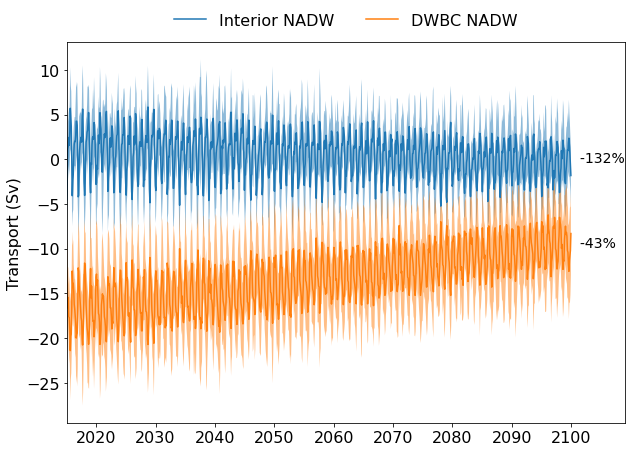

In [8]:
plt.figure(1,figsize=(10,7))
plt.plot(tdate,NADWNmean,label='Interior NADW')
plt.fill_between(tdate,NADWNmean-NADWNstd,NADWNmean+NADWNstd,alpha=0.5)
plt.plot(tdate,NADWSmean,label='DWBC NADW')
plt.fill_between(tdate,NADWSmean-NADWSstd,NADWSmean+NADWSstd,alpha=0.5)
plt.legend(loc='lower center',bbox_to_anchor=(0.5,1),ncol=2,prop={'size': 16},frameon=False)
plt.xlim(left=tdate[0],right=pd.Timestamp('2109-01-16'))
plt.ylabel('Transport (Sv)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ssp99mean_NADWN = np.nanmean(NADWNmean[-10*12::])
ssp99mean_NADWS = np.nanmean(NADWSmean[-10*12::])

dcl_NADWN = 100*(ssp99mean_NADWN - histmean_NADWN)/histmean_NADWN
dcl_NADWS = 100*(ssp99mean_NADWS - histmean_NADWS)/histmean_NADWS


plt.text(tdate[-1],ssp99mean_NADWN,'  ' + str(int(dcl_NADWN)) + '%',fontsize=14)
plt.text(tdate[-1],ssp99mean_NADWS,'  ' + str(int(dcl_NADWS)) + '%',fontsize=14)

print(str(ssp99mean_NADWN) + ' - ' + str(np.std(NADWNmean[-10*12::])))
print(str(ssp99mean_NADWS) + ' - ' + str(np.std(NADWSmean[-10*12::])))


#### Difference between historical and SSP585 period: dx,dz and vertically summed plots

/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: Mean of empty slice
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/users/jmecki

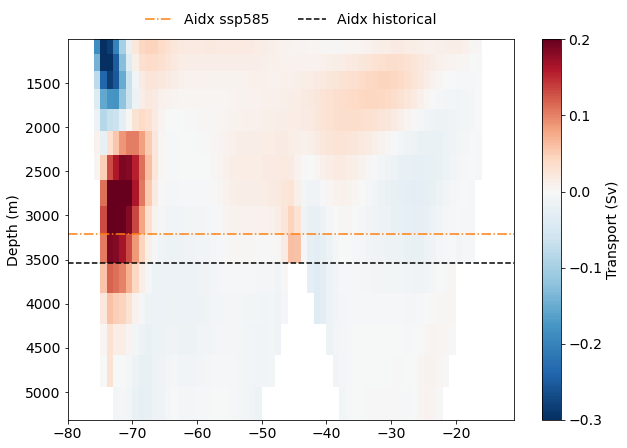

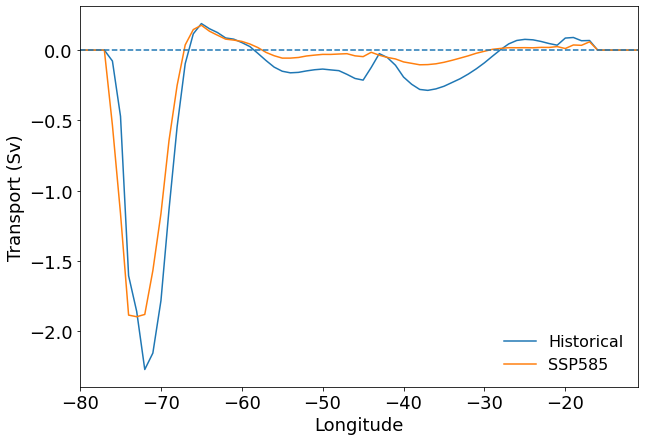

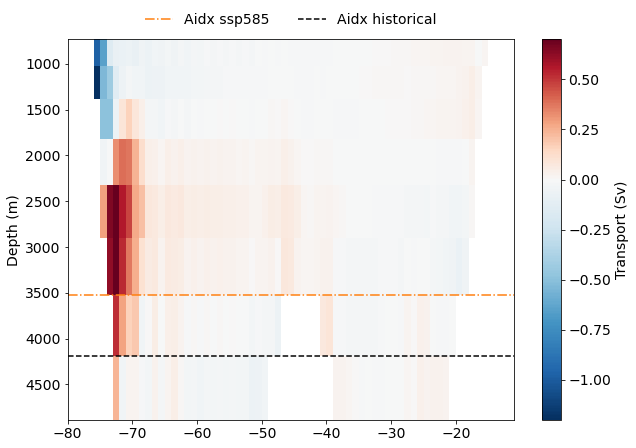

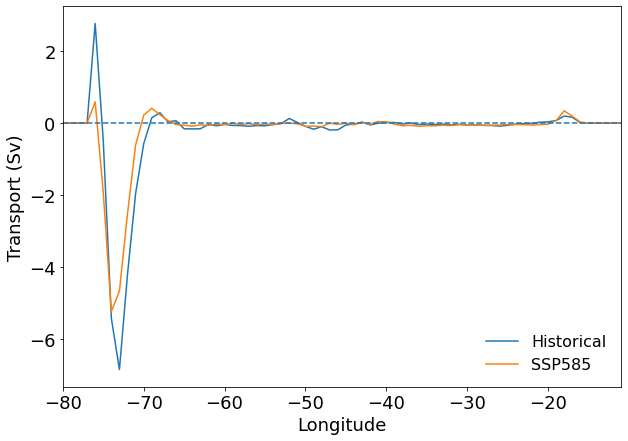

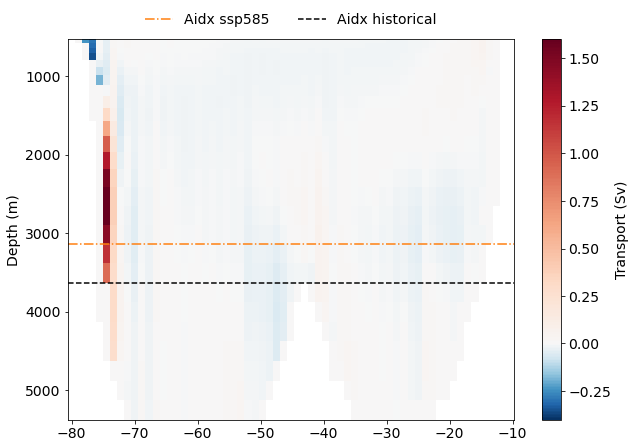

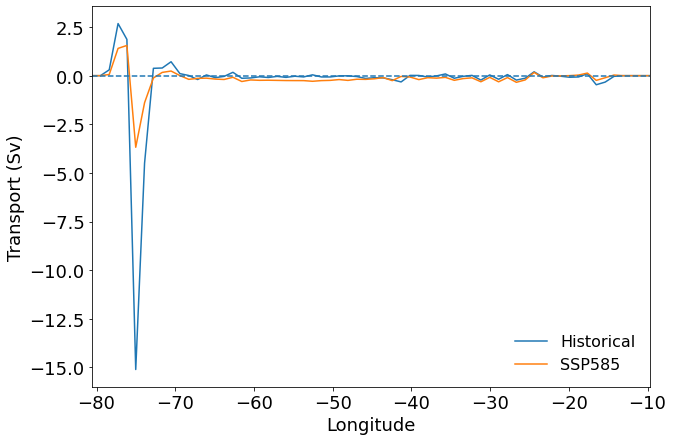

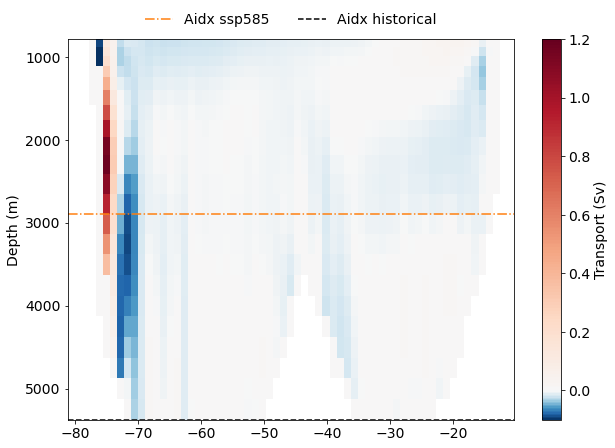

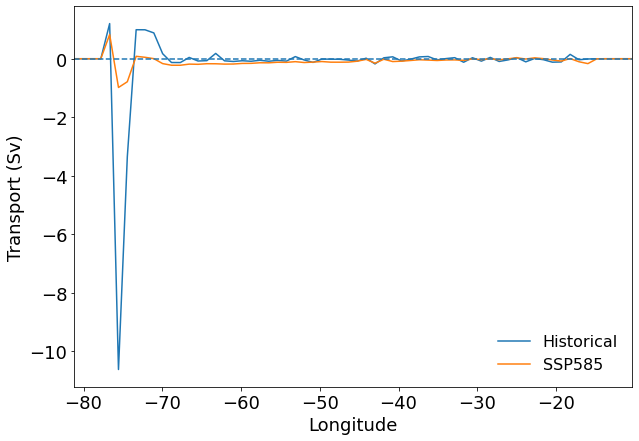

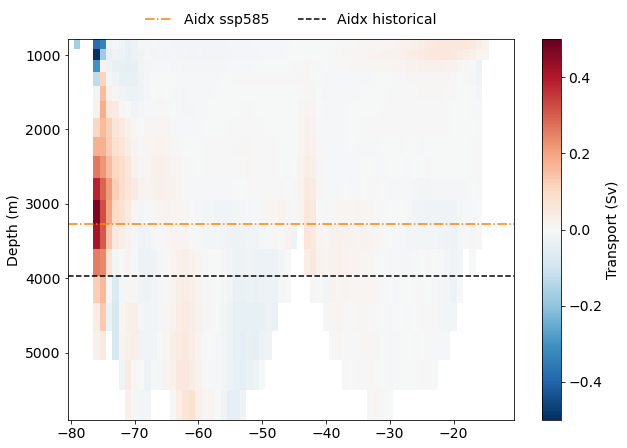

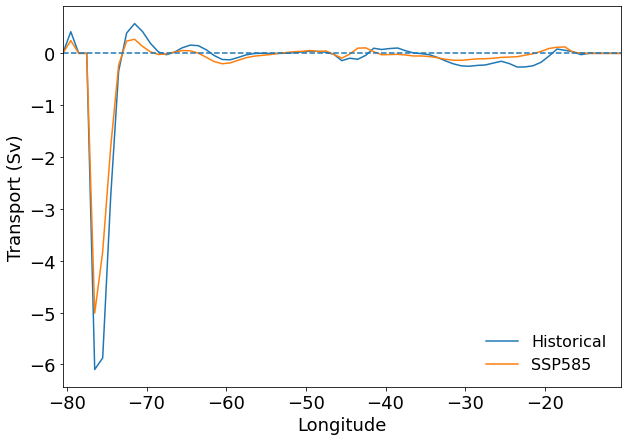

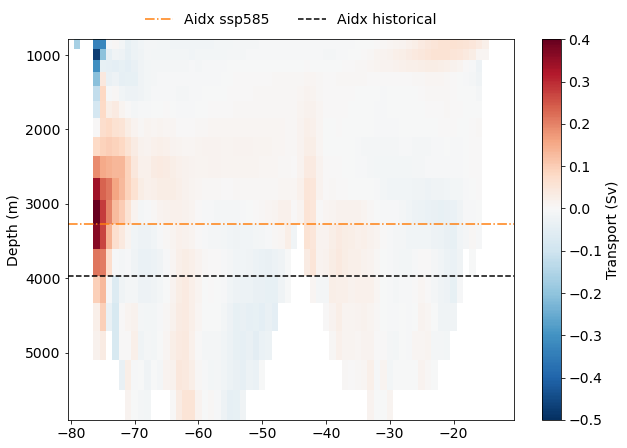

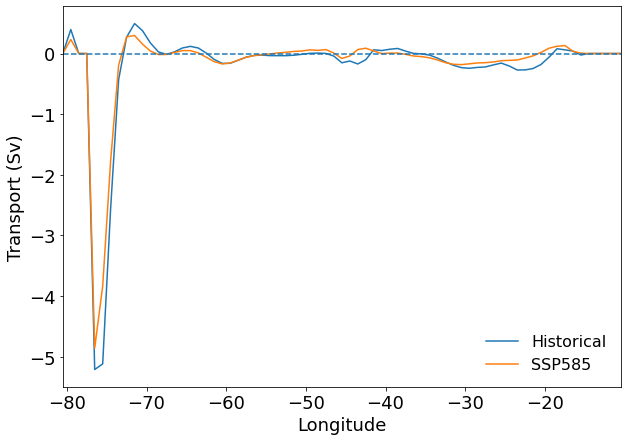

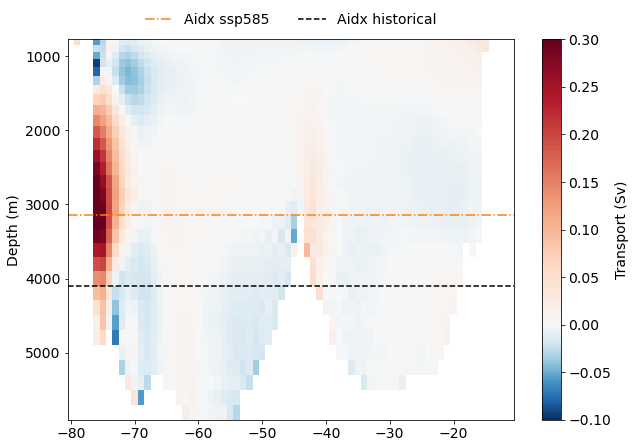

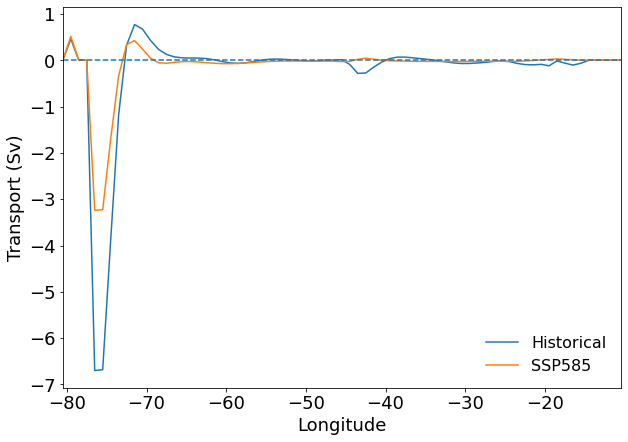

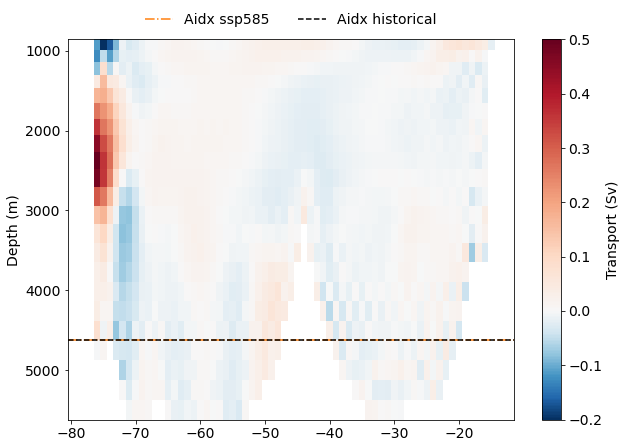

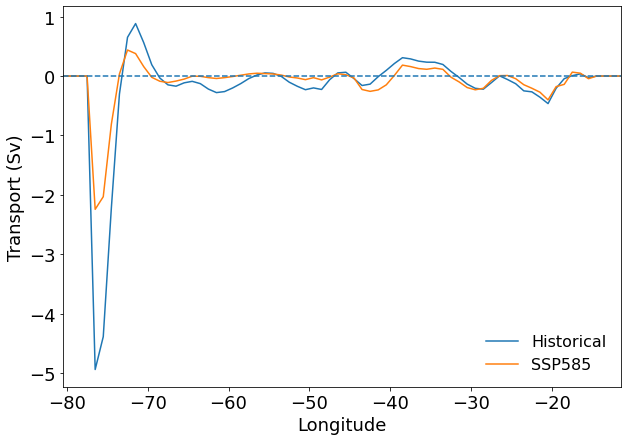

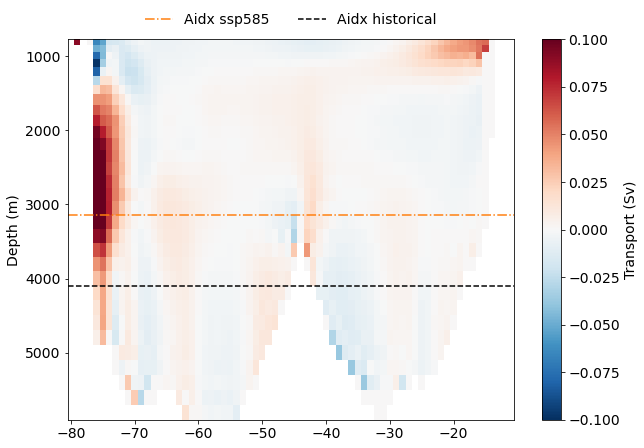

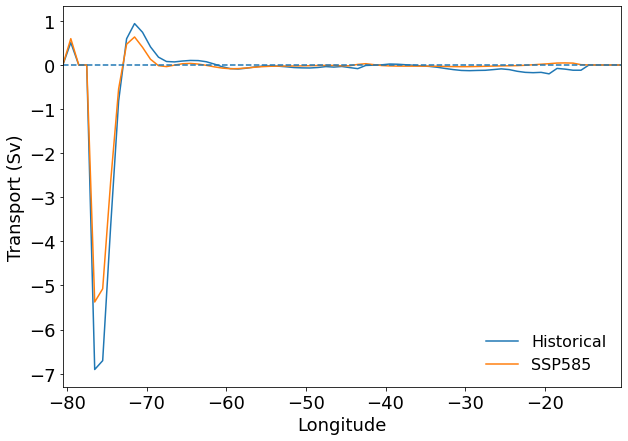

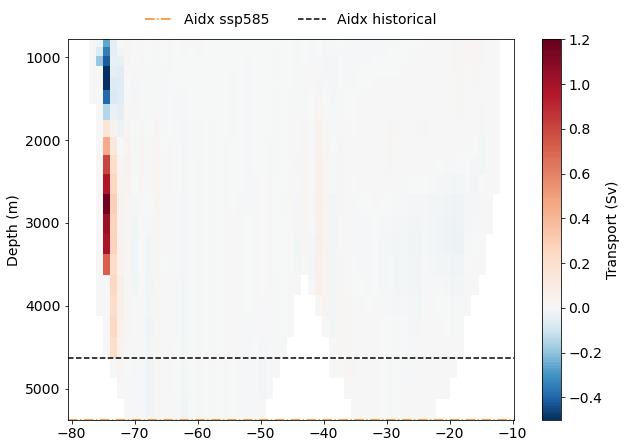

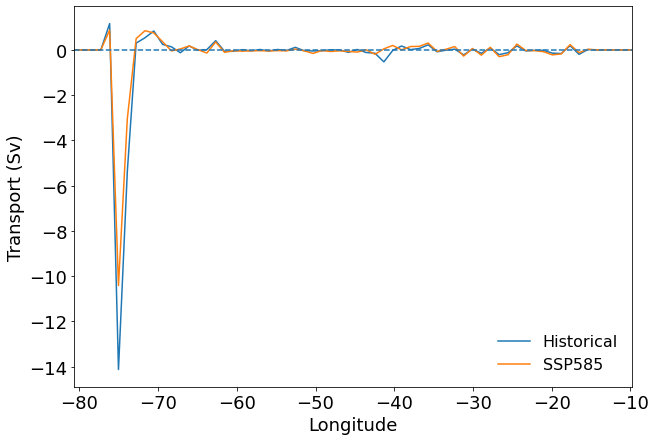

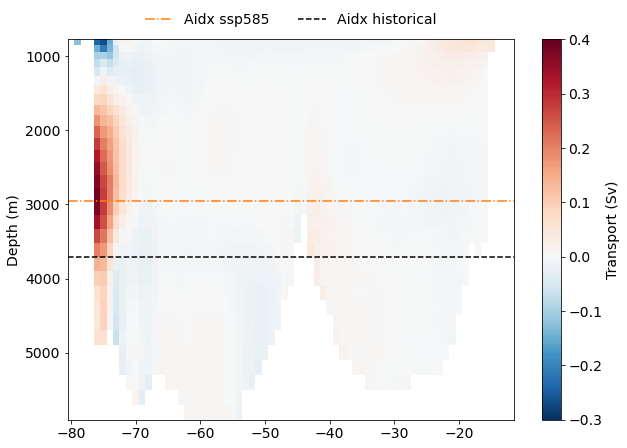

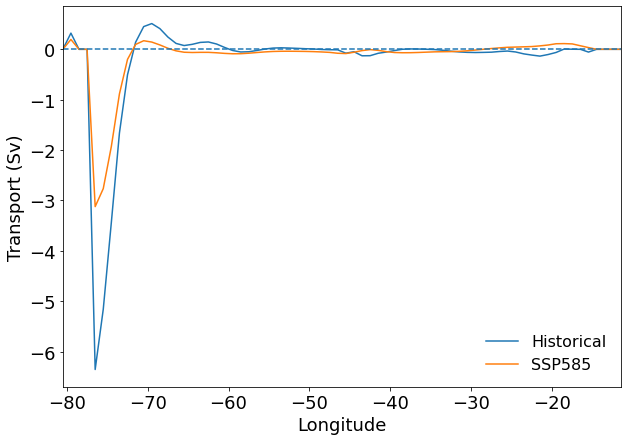

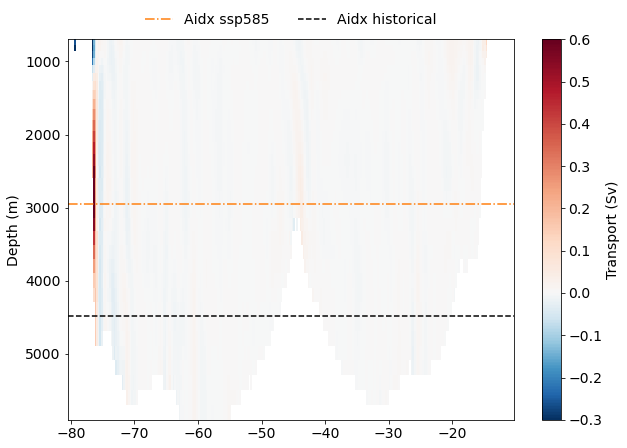

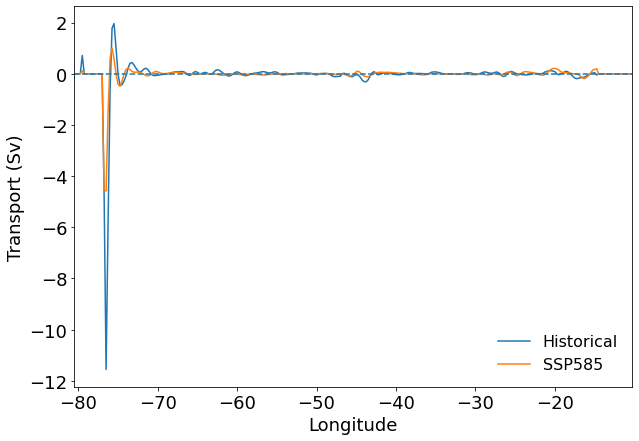

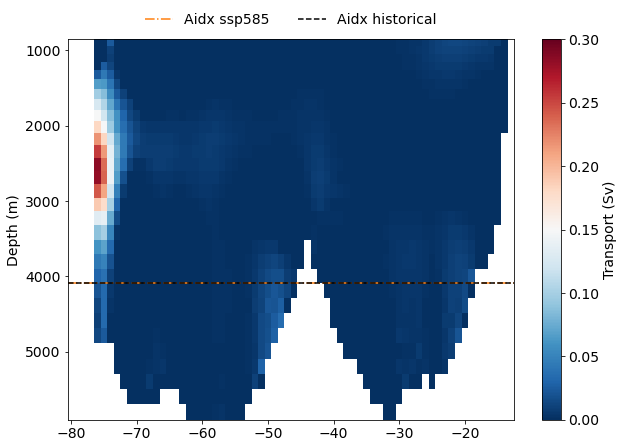

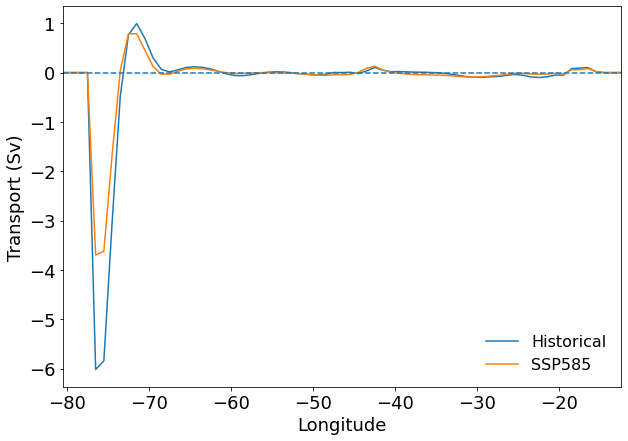

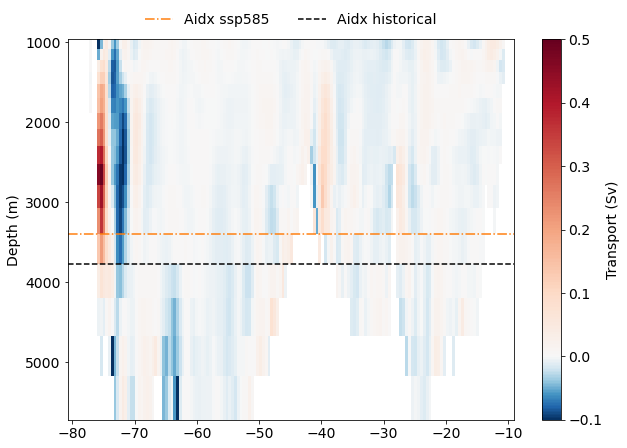

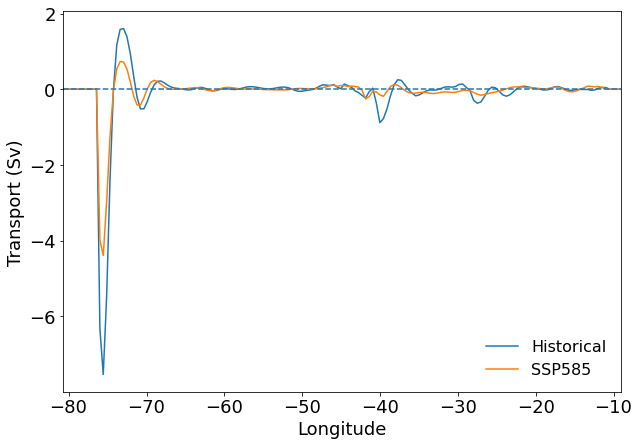

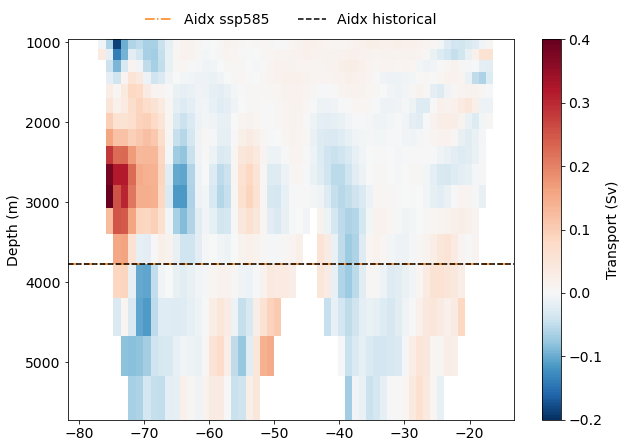

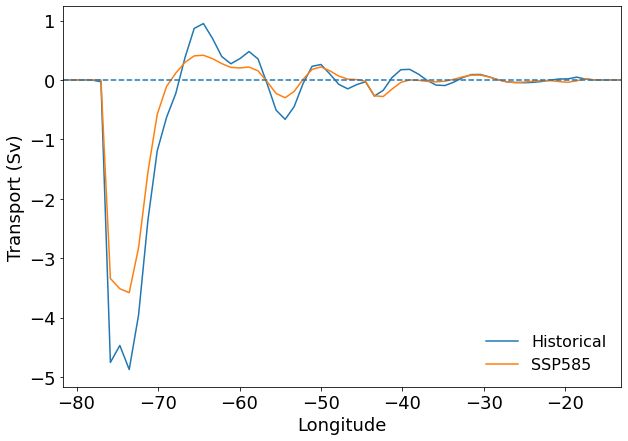

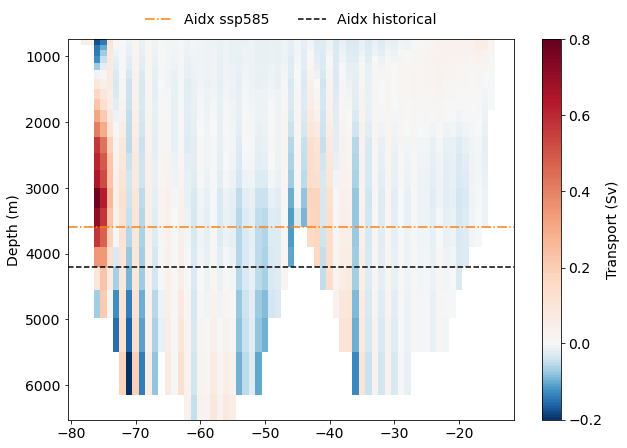

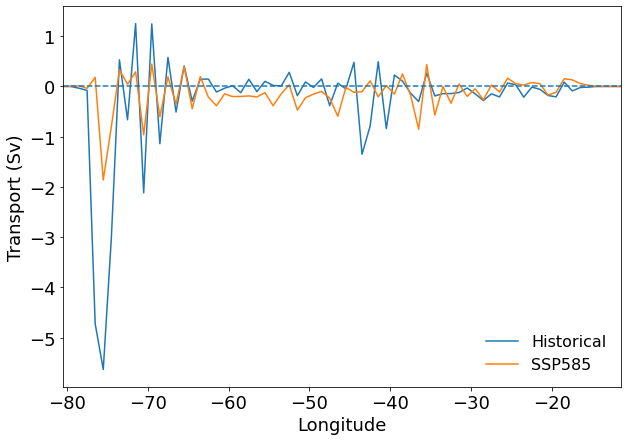

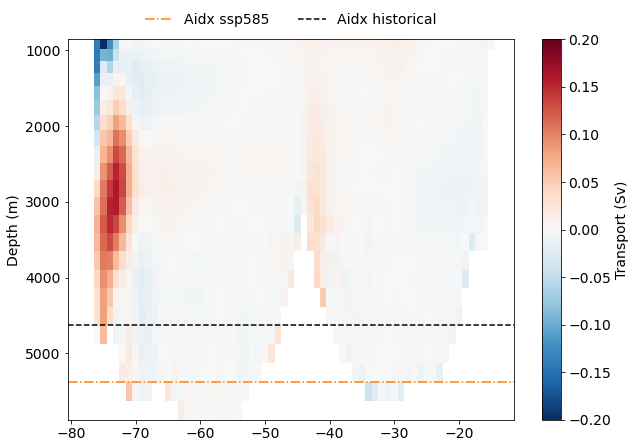

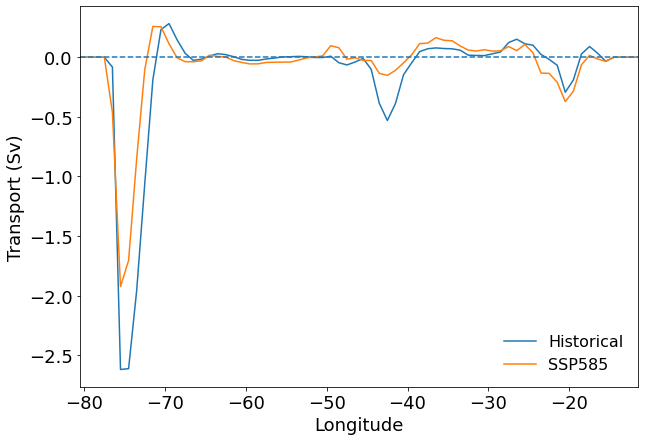

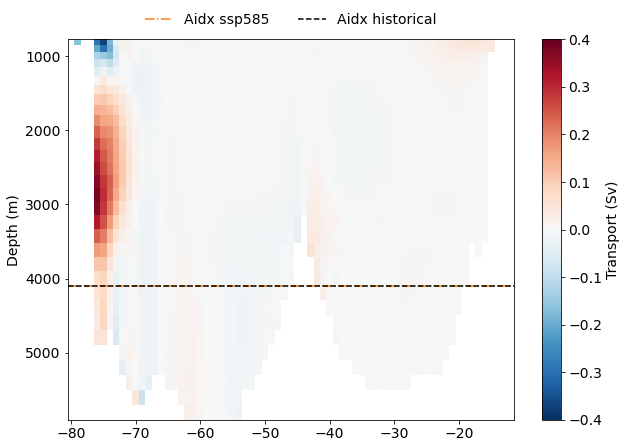

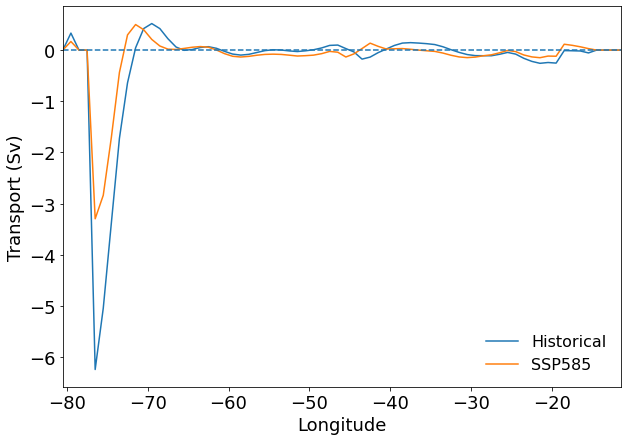

In [10]:
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f3',
           'r1i1p1f3','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
EXP1   = 'historical'
EXP2   = 'ssp585'

for mod in range (len(totmod)):
    #Compute historical cross sections
    outfile = ('/home/users/jordi/section26data/' + totmod[mod] + '_' + EXP1 + '_' + ENS[mod] + '.nc')
    ncid    = Dataset(outfile,'r')
    lev     = ncid.variables['lev'][:]
    lat     = np.squeeze(ncid.variables['lat'][:,:])
    lon     = np.squeeze(ncid.variables['lon'][:,:])
    tp10    = ncid.variables['tp10_BS'][:,:,:]
    dx      = ncid.variables['dx'][0,:]
    ncid.close()
    
    tprow10    = np.nansum(np.nanmean(tp10,axis=0),axis=1)
    mocbtv     = -1*np.nancumsum(tprow10[::-1])[::-1]
    ilevmin    = np.nanargmin(np.abs(lev-200))         #Find index where lev = 200, so outlier where imax = 0 is solved
    ilevmax    = np.nanargmin(np.abs(lev-2000))         #Find index where lev = 2000, so outlier where imax = -1 is solved
    imax2      = np.where(mocbtv[ilevmin:ilevmax] == max(mocbtv[ilevmin:ilevmax]))
    imax1      = imax2[0]
    imaxmean_hist  = imax1[0] + ilevmin
        
    #Aidx
    tprow10low = tprow10[int(imaxmean_hist)::]
    for m in range (1,len(tprow10low)):                    #start at 1, otherwise the first and last point will be compared
        if tprow10low[m]>0 and tprow10low[m-1]<0:
            Aidxmean_hist = m + imaxmean_hist
                
    AABWcheck = tprow10low[int(Aidxmean_hist)::]                    #Make sure sum(AABW) is positive
    if sum(AABWcheck) < 0:
        Aidxmean_hist = len(tprow10low) - 1
    
    if totmod[mod] in ['CESM2-WACCM','CIESM','FIO-ESM-2-0']:        #Correct for shift Atlantic
        lon = lon - 100
            
    
    #Compute ssp585 cross sections
    outfile = ('/home/users/jordi/section26data/' + totmod[mod] + '_' + EXP2 + '_' + ENS[mod] + '.nc')
    ncid    = Dataset(outfile,'r')
    tp85    = ncid.variables['tp85_BS'][:,:,:]
    ncid.close()
       
    tprow10    = np.nansum(np.nanmean(tp85[-120::],axis=0),axis=1)
    mocbtv     = -1*np.nancumsum(tprow10[::-1])[::-1]
    ilevmin    = np.nanargmin(np.abs(lev-200))         #Find index where lev = 200, so outlier where imax = 0 is solved
    ilevmax    = np.nanargmin(np.abs(lev-2000))         #Find index where lev = 2000, so outlier where imax = -1 is solved
    imax2      = np.where(mocbtv[ilevmin:ilevmax] == max(mocbtv[ilevmin:ilevmax]))
    imax1      = imax2[0]
    imaxmean_ssp  = imax1[0] + ilevmin
        
    #Aidx
    tprow10low = tprow10[int(imaxmean_ssp)::]
    for m in range (1,len(tprow10low)):                    #start at 1, otherwise the first and last point will be compared
        if tprow10low[m]>0 and tprow10low[m-1]<0:
            Aidxmean_ssp = m + imaxmean_ssp
                
    AABWcheck = tprow10low[int(Aidxmean_ssp)::]                    #Make sure sum(AABW) is positive
    if sum(AABWcheck) < 0:
        Aidxmean_ssp = len(tprow10low) - 1
    
    if imaxmean_hist <= imaxmean_ssp:
        imaxmean = imaxmean_hist
    else:
        imaxmean = imaxmean_ssp
    
    #Compute change between historical and last 10 years of ssp585
    hist_2d = np.nanmean(tp10[:,int(imaxmean)::,:],axis=0)
    ssp_2d  = np.nanmean(tp85[-120::,int(imaxmean)::,:],axis=0)   
    diff_2d = ssp_2d - hist_2d

    diff_col = np.nansum(diff_2d,axis=0)
    
    plt.figure(mod,(10,7))
    plt.title(totmod[mod],fontsize=14)
    if np.round(np.nanmin(diff_2d),1) < 0:
        divnorm=colors.TwoSlopeNorm(vmin=np.round(np.nanmin(diff_2d),1), vcenter=0., vmax=np.round(np.nanmax(diff_2d),1))
    else:
        divnorm=colors.TwoSlopeNorm(vmin=-np.round(np.nanmin(diff_2d),1), vcenter=(np.round(np.nanmin(diff_2d),1)+np.round(np.nanmax(diff_2d),1))/2, vmax=np.round(np.nanmax(diff_2d),1))        
    plt.pcolormesh(lon,lev[int(imaxmean)::],diff_2d,cmap='RdBu_r',norm=divnorm)
    plt.gca().invert_yaxis()
    plt.axhline(y=lev[int(Aidxmean_ssp)],color='tab:orange',linestyle='-.',label='Aidx ssp585')
    plt.axhline(y=lev[int(Aidxmean_hist)],color='k',linestyle='--',label='Aidx historical')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    cbar = plt.colorbar()
    cbar.set_label('Transport (Sv)',size=14)
    cbar.ax.tick_params(labelsize=14) 
    plt.ylabel('Depth (m)',fontsize=14)
    plt.legend(loc='lower center',bbox_to_anchor=(0.5,1.0),ncol=2,prop={'size': 14},frameon=False,fontsize=18)
    
    plt.figure(mod+40,(10,7))
    plt.title(totmod[mod],fontsize=14)
    plt.plot(lon,np.nansum(hist_2d[0:(Aidxmean_hist-imaxmean),:],axis=0),label='Historical')
    plt.plot(lon,np.nansum(ssp_2d[0:(Aidxmean_ssp-imaxmean)],axis=0),label='SSP585')
    plt.axhline(y=0,linestyle='--')
    plt.xlabel('Longitude',fontsize=18)
    plt.xticks(fontsize=18)
    plt.ylabel('Transport (Sv)',fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim(left=lon[0],right=lon[-1])     
    plt.legend(loc='lower right',prop={'size': 16},frameon=False,fontsize=18)
    